# Lab 6

## Jennifer Vo, lab partners with William Olsen
INTRODUCTION: In this lab, we will be ...

## Setup

First let's setup our lab by making fake background data. For our background we will use a Poisson distribution with a mean of 100. Let's create this data and then plot it to visualize the background.

In [66]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
import math
import pickle

#this sets the size of the plots to something useful
plt.rcParams["figure.figsize"] = (10,8)

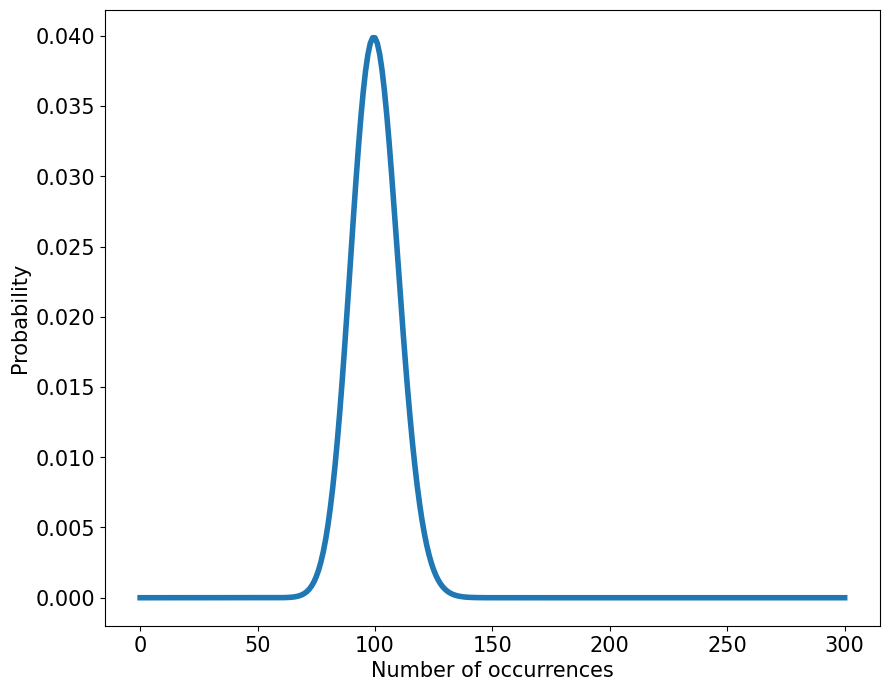

In [67]:
bkgd_mean = 100
bkgd_x = np.linspace(0,300,301)
bkgd_prob = stats.poisson.pmf(bkgd_x, bkgd_mean)

plt.plot(bkgd_x, bkgd_prob, linewidth = 4)
plt.tick_params(labelsize=15)
plt.xlabel('Number of occurrences', fontsize = 15)
plt.ylabel('Probability', fontsize = 15)
plt.show()

## Problem 1
The first problem that we'll look at is to determine where the 5$\sigma$ sensitivity threshold is. I will ask the following statistical question:
__How strong of a signal must I observe for my background to have a probability, corresponding to a significance of 5$\sigma$, of producing that signal?__

I can convert my statistical question to a mathematical expression. First, the Poisson distribution is discreet, with a probability mass function given by: $\frac{\lambda^{k} e^{-k}}{k!}$ which equals the probability of obtaining exactly k occurrences.

I will need to convert my threshold of 5$\sigma$ to a corresponding probability of obtaining that threshold using the survival function (sf) of scipy.stats.norm with a normal distribution of mean 0 and standard deviation 1. This integrates the normal distribution between x = 5 to x = $\infty$. Then, I will take this calculated probability and use the inverse survival function on a Poisson distribution with mean 100 to determine what corresponding number of occurences (signal value) I would need to see to get a significance of 5 $\sigma$.

Thus to answer my statistical question, I should solve for x in the following equation, where $\lambda$ = 100:
$$\int_{5}^{\infty} \frac{1}{\sqrt{2\pi}} e^{-x^2/2} dx = \sum_{k=x}^{\infty} \frac{\lambda^{k} e^{-k}}{k!} $$

In [68]:
sigma_a = 5
prob_a = stats.norm.sf(sigma_a)

signal_a = stats.poisson.isf(prob_a, bkgd_mean)
print(f'The signal I must observe for my background have a probability (corresponding to a 5 sigma significance) of producing that signal is {signal_a}.')

The signal I must observe for my background have a probability (corresponding to a 5 sigma significance) of producing that signal is 154.0.


From the plot, I can see that a signal of 154 corresponding to a 5 sigma significance is indeed what I would expect. The signal is greater than the mean and has a very small probability of occurring.

## Problem 2
Next I will inject a signal of strength 8 $\sigma$, and I will do this many times, say 5 times. (Inject this signal into your background data many times.)

In [69]:
# determine what is a signal of strength 8 sigma is
sigma_b = 8
prob_b = stats.norm.sf(sigma_b)

signal_b = stats.poisson.isf(prob_b, bkgd_mean)
print(f'The signal I must observe for my background to have a probability (corresponding to {sigma_b} sigma significance) of producing that signal is {signal_b}.')

The signal I must observe for my background to have a probability (corresponding to 8 sigma significance) of producing that signal is 190.0.


In [92]:
# define background data and inj_signal as an array
size = 100000
inj_signal = []
for i in range (0, size):
    inj_signal.append(signal_b)
    
N_good = size
bkgd = stats.poisson.rvs(bkgd_mean, size=N_good)
data1 = bkgd + inj_signal

I would like to first histogram how bright this observed signal appears to be.

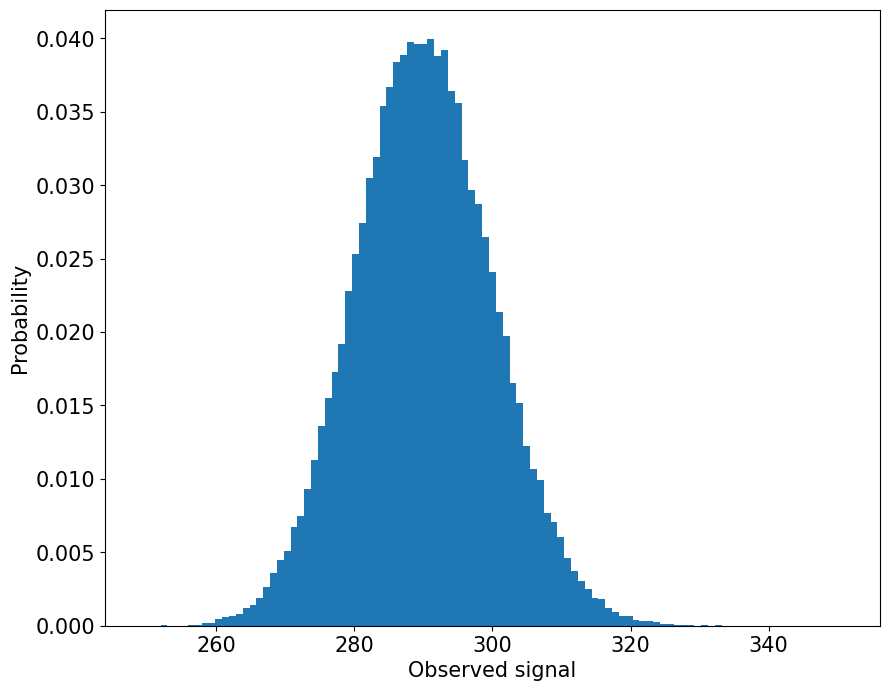

In [97]:
# histogram the data with the injected signal
plt.hist(data1, 103, density = 'True')
plt.tick_params(labelsize = 15)
plt.ylabel('Probability', fontsize = 15)
plt.xlabel('Observed signal', fontsize = 15)
plt.show()

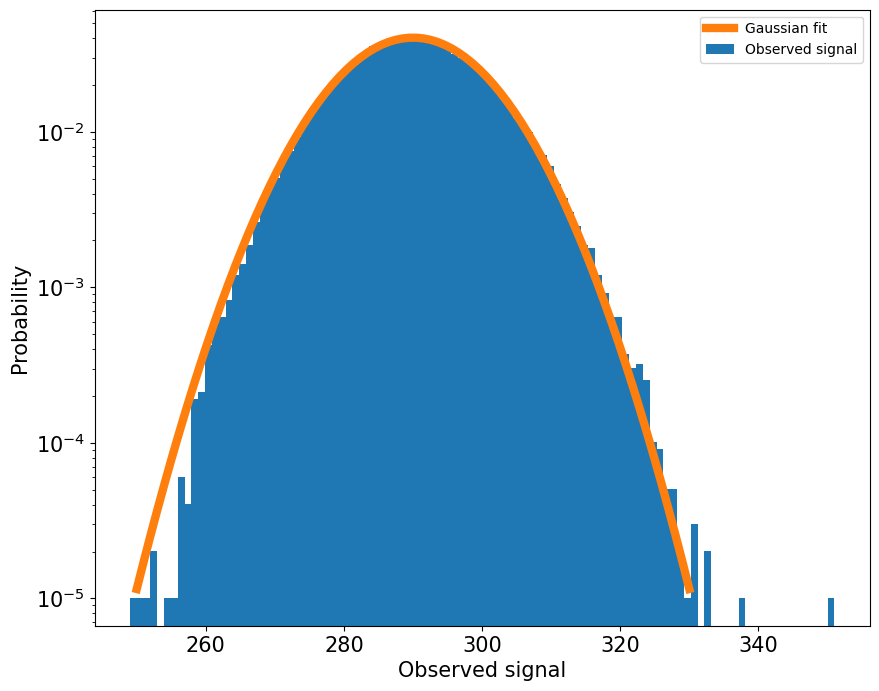

In [99]:
# histogram the data with the injected signal
x_norm = np.linspace(250, 330, 80)
p_norm = stats.norm.pdf(x_norm, loc = 290, scale = 9.9)

plt.hist(data1, 103, density = 'True', label = 'Observed signal')
plt.plot(x_norm, p_norm, linewidth = 6, label = 'Gaussian fit')
plt.yscale('log')
plt.tick_params(labelsize = 15)
plt.ylabel('Probability', fontsize = 15)
plt.xlabel('Observed signal', fontsize = 15)
plt.legend()
plt.show()

The shape of the histogram resembles a normal distribution with a mean at 290. This is consistent with the Central Limit Theorem, which states that as the sample size gets larger, the distribution of the sample approximates a normal distribution.

I confirmed this shape by plotting my histogram on a semilog plot and I observe that the plot resembles an upside down parabola, which is characteristic of a Gaussian.

This histogram is telling me that the observed signal is most likely to be 290, the mean. The probability of obtaining values less than or greater than 290 decreases with observed values farther from 290, and this relationship is symmetric about the mean which means the probability affect is the same on both sides.

My observed signals are all stronger than the true injected signal of 190. In this way my observed signals are biased. The distribution is symmetric about an average of 290, which is the sum of the background's mean (100) and the injected signal (190).

## Problem 3
Now, instead of a constant signal I will look at injecting multiple signals, this will result in multiple observation distributions for every different signal I inject. I am going to use a range that starts at 0 and I want it to extend well above 5 $\sigma$, perhaps 30 $\sigma$ or more.

In [100]:
# determine what is a signal of strength 8 sigma is
sigma_c = 30
prob_c = stats.norm.cdf(sigma_c)

signal_c = stats.poisson.ppf(prob_c, bkgd_mean)
print(f'The signal I must observe for my background to have a probability (corresponding to {sigma_c} sigma significance) of producing that signal is {signal_c}.')

The signal I must observe for my background to have a probability (corresponding to 30 sigma significance) of producing that signal is inf.


As we can see, I am unable to calculate a signal of strength greater than 8 sigma significance with cloud python capabilities. Given that 5 sigma corresponds to 154 and 8 sigma corresponds to 190, this relationship is approximately $100 + 10 \sigma$. I will approximate that 30 sigma corresponds to around 400. Thus, I will inject signals starting at 0 and ranging up through 400.

In [103]:
signals = np.random.uniform(0, 400, 100000)

I am simulating an experiment in which the background is Poisson-distributed with mean of 100, however the signals range from anywhere between 0 and 400. Thus every observed value will have a different probability depending on the injected signal. To plot this I will make a 2D histogram of the injected signals versus the observed data.

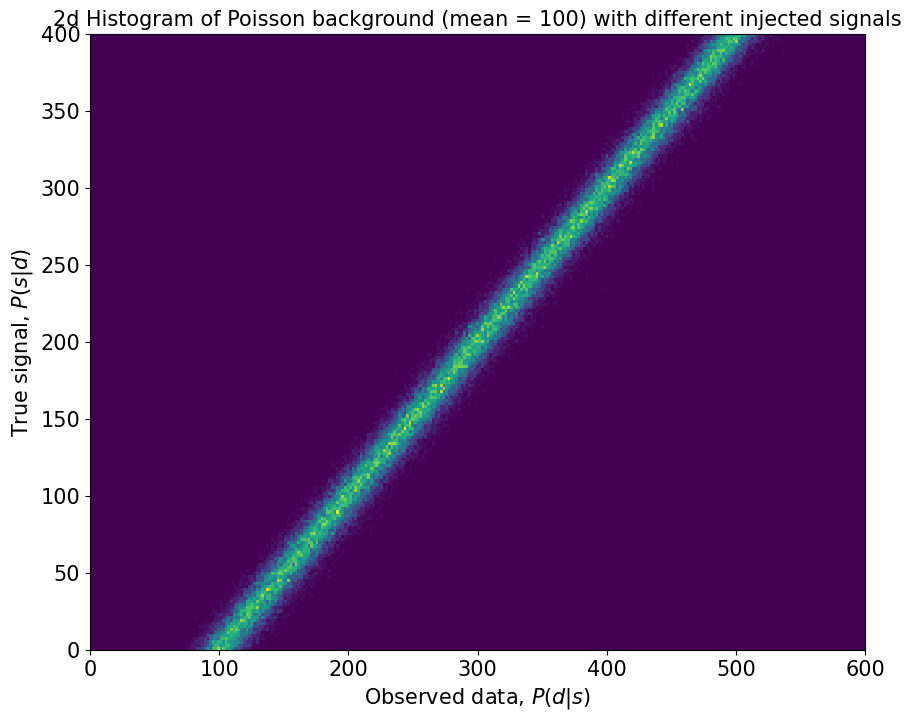

In [123]:
# Add signal to background
data2 = bkgd + signals

# Make histogram
# observed signals (data) - x axis edges
dataedges = np.linspace(0,600,300)
# true signals - y axis edges
signaledges = np.linspace(0,400,200)

Psd, temp, temp2 = np.histogram2d(data2, signals, bins=(dataedges, signaledges), density=True)

datacenters = (dataedges[:-1] + dataedges[1:]) / 2
signalcenters = (signaledges[:-1] + signaledges[1:]) / 2

plt.pcolormesh(datacenters, signalcenters, Psd.T, shading = 'auto')
plt.title(f'2d Histogram of Poisson background (mean = 100) with different injected signals', fontsize=15)
plt.tick_params(labelsize=15)
plt.ylabel('True signal, $P(s|d)$', fontsize = 15)
plt.xlabel('Observed data, $P(d|s)$', fontsize = 15)
plt.show()

b) For the same injected signal power as in problem 2, show that you get the same answer.

c) Now reverse the problem, select an observed data value (pick something quite a bit stronger than 5σ) and create a 1D histogram of the true signal probability given the observed data. Describe the meaning of this histogram.

d) For your observed signal, what is the 1σ uncertainty on the true signal strength?

e) Discuss the answer to part d in some depth. Is it symmetric? Is it biased? Does this make sense?